# Data Preparation

In [10]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta

import ta
from statistics import mean
from sklearn.preprocessing import MinMaxScaler

import util_functions as uf

# Get Data

In [92]:
df = uf.getdata('NVDA',[20, 50],'Close')

[*********************100%%**********************]  1 of 1 completed


In [93]:
df['rsi'] = ta.momentum.rsi(df['Close'])

In [94]:
df['macd'] = ta.trend.macd(df['Close'])

In [95]:
# Calculate the Bollinger Bands
bb = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)

# Retrieve the upper, middle, and lower bands
df['upper_band'] = bb.bollinger_hband()
df['middle_band'] = bb.bollinger_mavg()
df['lower_band'] = bb.bollinger_lband()

In [96]:
df['stoch_oscillator'] = ta.momentum.stoch(high=df['High'], low=df['Low'], close=df['Close'])

# Remove NA

In [97]:
df = df.dropna(subset=['sma_20','sma_50','stoch_oscillator'])

In [98]:
df['next_day_close'] = df['Close'].shift(-1)

In [99]:
df = df.dropna(subset=['next_day_close'])

In [100]:
df = df.drop(columns='ticker')

# Scale df

In [125]:
df_x = df.drop(columns=['Date','next_day_close'])
df_y = df[['next_day_close']]

In [126]:
scaler_x = MinMaxScaler()

scaler_x.fit(df_x)
scaled_data_x = scaler_x.transform(df_x)
df_scaled_x = pd.DataFrame(scaled_data_x, columns=df_x.columns)

In [129]:
scaler_y = MinMaxScaler()

scaler_y.fit(df_y)
scaled_data_y = scaler_y.transform(df_y)
df_scaled_y = pd.DataFrame(scaled_data_y, columns=df_y.columns)

In [21]:
df_reset_index = df.reset_index(drop=True).reset_index()

In [110]:
df_scaled_x = df_scaled_x.reset_index()

In [114]:
df_scaled_full_x = pd.merge(left=df_reset_index[['index','Date']],right=df_scaled_x, on='index')

In [115]:
df_scaled_full_x = df_scaled_full_x.drop(columns='index')

# Remove Outliers

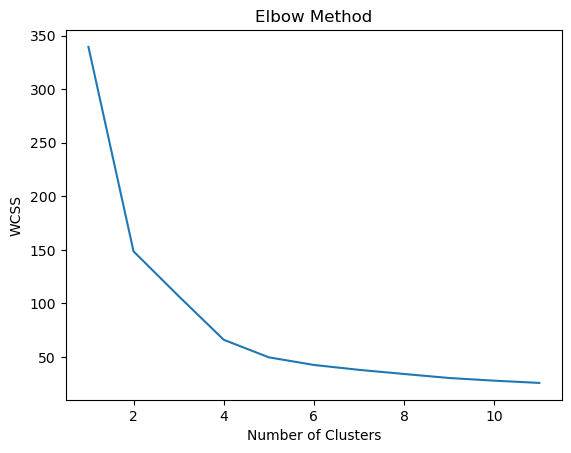

In [118]:
plot_k_clusters = uf.kmeans_elbow_method(df_scaled_full_x.drop(columns='Date'))

In [119]:
df_outliers = uf.detect_outliers_kmeans(df_scaled_full_x.drop(columns='Date'), 4)

In [120]:
len(df_outliers)

26

In [156]:
df_scaled_full_x = df_scaled_full_x[~df_scaled_full_x.index.isin(df_outliers.index.tolist())]

In [131]:
df_scaled_y = df_scaled_y[~df_scaled_y.index.isin(df_outliers.index.tolist())]

# Company Fundamentals

In [133]:
import requests
import json

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol=IBM&apikey=M482KPOEHSDW3G1M'
r = requests.get(url)
data = r.json()

df_normalse = pd.json_normalize(data)

In [134]:
df_quarterly= pd.json_normalize(df_normalse['quarterlyReports'])

In [135]:
df_normalise_2023_q4 = pd.json_normalize(df_quarterly[0])
df_normalise_2023_q3 = pd.json_normalize(df_quarterly[1])
df_normalise_2023_q2 = pd.json_normalize(df_quarterly[2])
df_normalise_2023_q1 = pd.json_normalize(df_quarterly[3])
df_normalise_2022_q4 = pd.json_normalize(df_quarterly[4])
df_normalise_2022_q3 = pd.json_normalize(df_quarterly[5])
df_normalise_2022_q2 = pd.json_normalize(df_quarterly[6])
df_normalise_2022_q1 = pd.json_normalize(df_quarterly[7])


In [136]:
df_comp_fund = pd.concat([df_normalise_2023_q4,df_normalise_2023_q3,df_normalise_2023_q2,df_normalise_2023_q1,
           df_normalise_2022_q4,df_normalise_2022_q3,df_normalise_2022_q2,df_normalise_2022_q1])
           

In [137]:
df_comp_fund = df_comp_fund.drop(columns='reportedCurrency')

In [138]:
scaler = MinMaxScaler()
scaler.fit(df_comp_fund.drop(columns=['fiscalDateEnding','investmentIncomeNet']))
scaled_data = scaler.transform(df_comp_fund.drop(columns=['fiscalDateEnding','investmentIncomeNet']))
df_comp_fund_scaled = pd.DataFrame(scaled_data, columns=df_comp_fund.drop(columns=['fiscalDateEnding','investmentIncomeNet']).columns)

In [139]:
scaled_data.shape

(8, 23)

In [140]:
df_comp_fund_reset_index = df_comp_fund.reset_index(drop=True).reset_index()

In [141]:
df_comp_fund_scaled = df_comp_fund_scaled.reset_index()

In [142]:
df_comp_fund= df_comp_fund_reset_index[['index','fiscalDateEnding']].merge(df_comp_fund_scaled, on='index')

In [143]:
df_comp_fund = df_comp_fund.drop(columns = 'index')

In [144]:
df_comp_fund['fiscalDateEnding'] = pd.to_datetime(df_comp_fund['fiscalDateEnding'])

# Merge Data

In [145]:
df_scaled_full['quarter'] = df_scaled_full['Date'].dt.to_period('Q')

In [43]:
df_comp_fund['quarter'] = df_comp_fund['fiscalDateEnding'].dt.to_period('Q')

In [44]:
df = df_scaled_full.merge(df_comp_fund, on='quarter', how='left')

In [161]:
df = pd.concat([df_scaled_full_x, df_scaled_y], axis=1)

In [162]:
df

,Date,Open,High,Low,Close,Volume,sma_20,sma_50,rsi,macd,upper_band,middle_band,lower_band,stoch_oscillator,next_day_close
0,2022-03-15,0.125310,0.131944,0.133382,0.144225,0.235514,0.161428,0.206931,0.336474,0.110745,0.156024,0.161428,0.172987,0.578067,0.162926
1,2022-03-16,0.148859,0.150143,0.156862,0.162926,0.365913,0.159988,0.204931,0.448473,0.134797,0.150922,0.159988,0.176952,0.958282,0.166241
2,2022-03-17,0.156225,0.153003,0.166178,0.166241,0.220939,0.158732,0.203323,0.466829,0.157060,0.145524,0.158732,0.181805,0.982300,0.186955
3,2022-03-18,0.164292,0.173163,0.175291,0.186955,0.409008,0.160133,0.202913,0.571558,0.191393,0.151196,0.160133,0.176906,0.980829,0.190405
4,2022-03-21,0.184585,0.179968,0.192337,0.190405,0.307994,0.162360,0.202400,0.587478,0.221173,0.158002,0.162360,0.172374,0.936034,0.187827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,2024-03-01,0.820143,0.823732,0.870959,0.872425,0.224454,0.882800,0.873718,0.826875,0.821426,0.837751,0.882800,0.949699,0.993333,0.908745
494,2024-03-04,0.869212,0.886710,0.925332,0.908745,0.325356,0.896537,0.886387,0.877273,0.861806,0.857504,0.896537,0.954512,0.885596,0.917671
495,2024-03-05,0.882757,0.868056,0.921499,0.917671,0.256331,0.908514,0.899846,0.888698,0.893003,0.878285,0.908514,0.953461,0.919573,0.951266
496,2024-03-06,0.915454,0.910395,0.967356,0.951266,0.301303,0.923260,0.913965,0.928736,0.936110,0.902278,0.923260,0.954514,0.956751,1.000000


In [163]:
#df = df.drop(columns=['Date','quarter'])
df = df.drop(columns=['Date'])

# Feature engineering

In [164]:
# Calculate the correlation coefficients between market indicators and stock prices
correlation_matrix = df.corr()
correlation_with_stock_prices = correlation_matrix['next_day_close'].dropna()
relevant_indicators = correlation_with_stock_prices[abs(correlation_with_stock_prices) > 0.5].index.tolist()

# Identify relevant indicators

In [166]:
relevant_indicators

['Open',
 'High',
 'Low',
 'Close',
 'sma_20',
 'sma_50',
 'rsi',
 'macd',
 'upper_band',
 'middle_band',
 'lower_band',
 'next_day_close']

In [165]:
import statsmodels.formula.api as sm


# Train Model

In [167]:
# Check for NaN values
nan_locations = df.isna().any()

# Get the columns with NaN values
columns_with_nan = nan_locations[nan_locations].index.tolist()

# Get the rows with NaN values
rows_with_nan = df[df.isna().any(axis=1)].index.tolist()


In [168]:
df = df.fillna(0)

In [169]:
df = df[relevant_indicators]

In [170]:
df

,Open,High,Low,Close,sma_20,sma_50,rsi,macd,upper_band,middle_band,lower_band,next_day_close
0,0.125310,0.131944,0.133382,0.144225,0.161428,0.206931,0.336474,0.110745,0.156024,0.161428,0.172987,0.162926
1,0.148859,0.150143,0.156862,0.162926,0.159988,0.204931,0.448473,0.134797,0.150922,0.159988,0.176952,0.166241
2,0.156225,0.153003,0.166178,0.166241,0.158732,0.203323,0.466829,0.157060,0.145524,0.158732,0.181805,0.186955
3,0.164292,0.173163,0.175291,0.186955,0.160133,0.202913,0.571558,0.191393,0.151196,0.160133,0.176906,0.190405
4,0.184585,0.179968,0.192337,0.190405,0.162360,0.202400,0.587478,0.221173,0.158002,0.162360,0.172374,0.187827
...,...,...,...,...,...,...,...,...,...,...,...,...
493,0.820143,0.823732,0.870959,0.872425,0.882800,0.873718,0.826875,0.821426,0.837751,0.882800,0.949699,0.908745
494,0.869212,0.886710,0.925332,0.908745,0.896537,0.886387,0.877273,0.861806,0.857504,0.896537,0.954512,0.917671
495,0.882757,0.868056,0.921499,0.917671,0.908514,0.899846,0.888698,0.893003,0.878285,0.908514,0.953461,0.951266
496,0.915454,0.910395,0.967356,0.951266,0.923260,0.913965,0.928736,0.936110,0.902278,0.923260,0.954514,1.000000


# Check for overfitting

In [183]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set the window size and step size for cross-validation
window_size = 80
step_size = 50

# Initialize lists to store the performance metrics
mse_scores_test = []
mse_scores_train = []

# Perform rolling window cross-validation
for start in range(0, len(df) - window_size + 1, step_size):
    end = start + window_size
    
    # Split the data into training and validation sets
    train_data = df.iloc[start:end]
    test_data = df.iloc[end:end+step_size]

    train_data_endog = train_data['next_day_close']
    train_data_exog = train_data.drop(columns='next_day_close')

    test_data_endog = test_data['next_day_close']
    test_data_exog = test_data.drop(columns='next_day_close')
    
    # Fit the ARIMAX model
    model = ARIMA(endog=train_data_endog, exog=train_data_exog, order=(0, 0, 0))
    model_fit = model.fit()

    # Make predictions
    test_predictions = model_fit.get_forecast(steps=len(test_data), exog=test_data_exog)
    train_predictions = model_fit.get_forecast(steps=len(train_data), exog=train_data_exog)

    val_predictions_mean = test_predictions.predicted_mean
    val_predictions_mean = val_predictions_mean.values.reshape(-1,1)
    test_pred = scaler_y.inverse_transform(val_predictions_mean)

    test_endo = test_data_endog.values.reshape(-1,1)
    test_endo = scaler_y.inverse_transform(test_endo)

    train_predictions_mean = train_predictions.predicted_mean
    train_pred = train_predictions_mean.values.reshape(-1,1)
    train_pred = scaler_y.inverse_transform(train_pred)

    train_endo = train_data_endog.values.reshape(-1,1)
    train_endo = scaler_y.inverse_transform(train_endo)

    #Calculate mean squared error (MSE) as the performance metric
    mse_test = mean_squared_error(test_endo, test_pred)
    mse_scores_test.append(round(mse_test,4))

    mse_train = mean_squared_error(train_endo, train_pred)
    mse_scores_train.append(round(mse_train,4))

In [184]:
mse_scores_test

[79.4697, 155.2318, 64.2945, 64.6727, 196.6647, 1328.0172, 193.4469, 1636.0136]

In [185]:
mse_scores_train

[65.9753, 33.77, 27.5402, 32.3501, 38.1617, 107.3088, 93.6042, 80.5352]

# Find Best Order

In [79]:
train_size = int(len(df) * 0.8)  # 80% for training
train_data = df[:train_size]
test_data = df[train_size:]

In [80]:
train_data_endog = train_data['next_day_close']
train_data_exog = train_data.drop(columns='next_day_close')

In [81]:
test_data_endog = test_data['next_day_close']
test_data_exog = test_data.drop(columns='next_day_close')

In [64]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Specify the range of orders to try
p_values = range(3)  # example: try orders (0, 0, 0), (1, 0, 0), and (2, 0, 0)
d_values = range(2)  # example: try orders (1, 0, 0) and (1, 1, 0)
q_values = range(3)  # example: try orders (1, 0, 0), (1, 0, 1), and (1, 0, 2)

best_aic = np.inf
best_order = None

# Iterate over different orders and select the best model based on AIC
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(endog=train_data_endog,exog=train_data_exog, order=(p, d, q))
                results = model.fit()
                aic = results.aic

                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
            except:
                continue

print("best_order= {}".format(best_order))

# Create the ARIMA model with selected indicators
model = ARIMA(train_data['next_day_close'], order=(p, d, q))
results = model.fit()

best_order= (0, 0, 0)


# ARIMA Model Prediction

In [66]:
from sklearn.metrics import accuracy_score

# Forecast on the test data
forecast = results.get_forecast(steps=len(test_data), exog=test_data_exog)

# Get the predicted values
predicted_values = forecast.predicted_mean


print(mean_squared_error(predicted_values, test_data['next_day_close']))
# Calculate the price change from the predicted values
predicted_price_change = np.diff(predicted_values)

# Create a binary target variable indicating if the price change is positive (1) or not (0)
predicted_price_up = (predicted_price_change > 0).astype(int)

# Calculate the actual price change from the test data
actual_price_change = np.diff(test_data['next_day_close'])

# Create a binary target variable for the actual price change
actual_price_up = (actual_price_change > 0).astype(int)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(actual_price_up, predicted_price_up)

# Print the accuracy
print(f"Accuracy: {accuracy}")

0.06287033859571431
Accuracy: 0.5652173913043478


# SARIMA Model

In [84]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Specify the order and seasonal order of the SARIMA model
order = (0, 0, 0)  # (p, d, q)
seasonal_order = (1, 0, 0, 6)  # (P, D, Q, seasonal_periods)

# Create the SARIMA model
model = SARIMAX(endog=train_data_endog, exog=train_data_exog, order=order, seasonal_order=seasonal_order)

# Fit the SARIMA model
results = model.fit()

# Forecast on the test data
forecast = results.get_forecast(steps=len(test_data), exog=test_data_exog)

# Get the predicted mean values
predicted_values = forecast.predicted_mean

# Calculate the price change from the predicted values
predicted_price_change = np.diff(predicted_values)

# Create a binary target variable indicating if the price change is positive (1) or not (0)
predicted_price_up = (predicted_price_change > 0).astype(int)

# Calculate the actual price change from the test data
actual_price_change = np.diff(test_data['next_day_close'])

# Create a binary target variable for the actual price change
actual_price_up = (actual_price_change > 0).astype(int)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(actual_price_up, predicted_price_up)

# Print the accuracy
print(f"Accuracy: {accuracy}")

Accuracy: 0.5368421052631579
